# Dynamic Pricing — Comprehensive Modeling Notebook

This notebook combines **all 8** modeling experiments into a single, optimised workflow:

| # | Experiment | Feature Set | Outlier Treatment |
|---|-----------|-------------|-------------------|
| 1 | EDA-selected features | EDA subset | None |
| 2 | All features | Full set | None |
| 3 | All features | Full set | Univariate (IQR) |
| 4 | All features | Full set | Multivariate (Isolation Forest) |
| 5 | SHAP analysis | Full set | None |
| 6 | SHAP-selected features | SHAP top 3 | None |
| (i) | EDA features | EDA subset | Univariate (IQR) |
| (ii) | EDA features | EDA subset | Multivariate (Isolation Forest) |


# 1. Install & Import Libraries

In [ ]:
#%pip install kagglehub shap catboost -q

In [94]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer

from catboost import CatBoostRegressor


# 2. Data Loading & Initial Inspection

In [95]:
# import kagglehub
# path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")
# df = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))
df = pd.read_csv( "dynamic_pricing.csv")

In [96]:
# Basic data inspection
print(f'Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns')
print(f'Duplicates: {df.duplicated().sum()}')
df.info()


Dataset shape: 1000 rows, 10 columns
Duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [ ]:
# Missing values
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'missing_count']
missing['percentage'] = missing['missing_count'] / df.shape[0] * 100
missing_only = missing[missing['missing_count'] > 0].sort_values(by='missing_count', ascending=False).reset_index(drop=True)
display(missing_only.style.background_gradient()) if len(missing_only) > 0 else print('No missing values found.')

No missing values found.


# 3. Create Target Variable (`adjusted_ride_cost`)

The adjusted ride cost is derived from the historical cost amplified by demand and supply multipliers:

```
adjusted_ride_cost = Historical_Cost_of_Ride × max(demand_mult, 0.8) × max(supply_mult, 0.8)
```

In [98]:
# --- Demand multiplier ---
high_demand_percentile = 75
low_demand_percentile  = 25

df['demand_multiplier'] = np.where(
    df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile)
)

# --- Supply multiplier ---
high_supply_percentile = 75
low_supply_percentile  = 25

df['supply_multiplier'] = np.where(
    df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
    np.percentile(df['Number_of_Drivers'], high_supply_percentile) / df['Number_of_Drivers'],
    np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers']
)

# --- Thresholds ---
demand_threshold_high = 1.2
demand_threshold_low  = 0.8
supply_threshold_high = 0.8
supply_threshold_low  = 1.2

# --- Adjusted cost ---
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

# --- Drop helper columns ---
df = df.drop(['demand_multiplier', 'supply_multiplier', 'Historical_Cost_of_Ride'], axis=1)

print('After target creation:', df.shape)
df.info()


After target creation: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   adjusted_ride_cost       1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


# 4. Feature Groups

Define feature splits used across all experiments.

In [99]:
# ---- Column groups ----
all_cat_cols  = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
all_num_cols  = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                 'Average_Ratings', 'Expected_Ride_Duration']

# Full feature set (Experiments 2, 3, 4, 5)
numerical_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
                      'Average_Ratings', 'Expected_Ride_Duration']
ordinal_features   = ['Customer_Loyalty_Status', 'Vehicle_Type']
nominal_features   = ['Location_Category', 'Time_of_Booking']

# EDA-selected feature subset (Experiments 1, (i), (ii))
eda_numerical_features = ['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration']
eda_ordinal_features   = ['Vehicle_Type']
eda_nominal_features   = ['Time_of_Booking']

# SHAP-selected features (Experiment 6)
shap_selected_numerical = ['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration']


# 5. Shared Utilities

Common functions shared across all experiments — defined once to avoid repetition.

In [100]:
def build_preprocessor(num_feats, ord_feats, nom_feats):
    """Build a ColumnTransformer preprocessor.
    
    Args:
        num_feats: List of numerical feature names (will be StandardScaled).
        ord_feats: List of ordinal feature names. Handles 'Customer_Loyalty_Status' and 'Vehicle_Type'.
        nom_feats: List of nominal feature names (will be OneHotEncoded).
    """
    numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    nominal_transformer   = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    encoder_loy = OrdinalEncoder(categories=[['Regular', 'Silver', 'Gold']])
    encoder_veh = OrdinalEncoder(categories=[['Economy', 'Premium']])

    transformers = [('num', numerical_transformer, num_feats)]
    if 'Customer_Loyalty_Status' in ord_feats:
        transformers.append(('loyl', encoder_loy, ['Customer_Loyalty_Status']))
    if 'Vehicle_Type' in ord_feats:
        transformers.append(('vehi', encoder_veh, ['Vehicle_Type']))
    if nom_feats:
        transformers.append(('nomi', nominal_transformer, nom_feats))

    return ColumnTransformer(transformers=transformers)


In [101]:
# Cross-validation & scoring strategy
cv         = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


def build_models_config(include_catboost=False):
    """Return a dict of model name -> {model, params} for experiment runs."""
    config = {
        "Linear Regression": {"model": LinearRegression(), "params": None},
        "Ridge": {
            "model": Ridge(random_state=42),
            "params": {"model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
        },
        "Lasso": {
            "model": Lasso(random_state=42, max_iter=2000),
            "params": {"model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]},
        },
        "Elastic Net": {
            "model": ElasticNet(random_state=42, max_iter=2000),
            "params": {
                "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
                "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
            },
        },
        "Decision Tree": {
            "model": DecisionTreeRegressor(random_state=42),
            "params": {
                "model__max_depth": [5, 10, 15, 20, None],
                "model__min_samples_split": [2, 5, 10],
                "model__min_samples_leaf": [1, 2, 4],
            },
        },
        "Random Forest": {
            "model": RandomForestRegressor(random_state=42, n_jobs=-1),
            "params": {
                "model__n_estimators": [50, 100, 200],
                "model__max_depth": [10, 20, None],
                "model__min_samples_split": [2, 5, 10],
            },
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                "model__n_estimators": [50, 100, 200],
                "model__learning_rate": [0.01, 0.1, 0.2],
                "model__max_depth": [3, 5, 7],
            },
        },
    }
    if include_catboost:
        config["CatBoost"] = {
            "model": CatBoostRegressor(random_state=42, verbose=0),
            "params": {
                "model__iterations": [200, 500, 800],
                "model__learning_rate": [0.01, 0.05, 0.1],
                "model__depth": [4, 6, 8],
                "model__l2_leaf_reg": [1, 3, 5, 7],
            },
        }
    return config


In [102]:
def run_experiment(X_train, X_test, y_train, y_test, preprocessor, models_config):
    """Train, tune and evaluate all models.
    
    Returns:
        results      : dict of name -> metrics + pipeline
        best_name    : name of the best model (lowest Test RMSE)
        best_model   : fitted pipeline of the best model
    """
    results = {}
    for name, config in models_config.items():
        pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", config["model"])])

        if config["params"] is not None:
            print(f"  Tuning {name}...")
            gs = GridSearchCV(pipeline, config["params"], cv=cv, scoring=mae_scorer, n_jobs=-1, verbose=0)
            gs.fit(X_train, y_train)
            best_pipeline = gs.best_estimator_
            print(f"    Best params: {gs.best_params_}")
        else:
            best_pipeline = pipeline
            best_pipeline.fit(X_train, y_train)

        y_train_pred = best_pipeline.predict(X_train)
        y_test_pred  = best_pipeline.predict(X_test)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2   = r2_score(y_train, y_train_pred)
        test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2    = r2_score(y_test, y_test_pred)

        results[name] = {
            "Train_RMSE": train_rmse, "Train_R2": train_r2,
            "Test_RMSE":  test_rmse,  "Test_R2":  test_r2,
            "pipeline":   best_pipeline,
        }
        print(f"  {name}: Train ${train_rmse:.2f} / R2={train_r2:.4f}  |  Test ${test_rmse:.2f} / R2={test_r2:.4f}")

    comparison_df = pd.DataFrame.from_dict(results, orient='index')[['Train_RMSE','Train_R2','Test_RMSE','Test_R2']]
    best_name     = comparison_df['Test_RMSE'].idxmin()
    best_model    = results[best_name]['pipeline']

    print(f"\n>>> Best model: {best_name}")
    print(f"    Test RMSE: ${results[best_name]['Test_RMSE']:.2f}  |  R2: {results[best_name]['Test_R2']:.4f}")
    print("\nModel Comparison:")
    print(comparison_df.drop(columns='pipeline', errors='ignore').to_string())
    return results, best_name, best_model


def plot_predictions(y_test, y_pred, model_name, label=''):
    """Side-by-side: Actual vs Predicted scatter + Residuals plot."""
    residuals = y_test - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=axes[0], color='steelblue')
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0].set_title(f'{model_name} ({label}): Actual vs. Predicted', fontsize=13)
    axes[0].set_xlabel('Actual Adjusted Ride Cost')
    axes[0].set_ylabel('Predicted Adjusted Ride Cost')

    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1], color='teal')
    axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
    axes[1].set_title(f'{model_name} ({label}): Residuals', fontsize=13)
    axes[1].set_xlabel('Predicted Adjusted Ride Cost')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')

    plt.tight_layout()
    plt.show()


# 6. Outlier Detection & Removal Utilities

In [103]:
def detect_univariate_outliers(df, cols):
    """Report IQR-based outliers for each numeric column."""
    n_rows = len(df)
    rows = []
    for col in cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        n_out = ((df[col] < lb) | (df[col] > ub)).sum()
        rows.append({'Feature': col, 'Lower': round(lb, 2), 'Upper': round(ub, 2),
                     'Outliers': n_out, 'Pct (%)': round(n_out / n_rows * 100, 2)})
    return pd.DataFrame(rows)


def remove_univariate_outliers(df, cols):
    """Remove IQR-based outliers for all specified columns (iterative)."""
    df_clean = df.copy()
    print(f'Original shape: {df_clean.shape}')
    for col in cols:
        Q1, Q3 = df_clean[col].quantile(0.25), df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        before = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lb) & (df_clean[col] <= ub)]
        print(f'  {col}: removed {before - len(df_clean)} rows -> shape {df_clean.shape}')
    return df_clean


def remove_multivariate_outliers_iso_forest(df, num_feats, ord_feats, nom_feats,
                                             contamination=0.05, random_state=42):
    """
    Detect and remove multivariate outliers using Isolation Forest.
    
    Note: Isolation Forest is tree-based so scaling has no impact,
    but categorical encoding is still needed.
    
    Returns:
        df_clean       : DataFrame with outliers removed
        outlier_indexes: List of dropped row indices
    """
    df_copy = df.copy()
    prep = build_preprocessor(num_feats, ord_feats, nom_feats)
    X_prepared = prep.fit_transform(df_copy)

    iso = IsolationForest(contamination=contamination, random_state=random_state, n_jobs=-1)
    df_copy['anomaly_label'] = iso.fit_predict(X_prepared)

    outlier_indexes = df_copy[df_copy['anomaly_label'] == -1].index.tolist()
    print(f'Outliers: {len(outlier_indexes)} ({len(outlier_indexes)/len(df)*100:.1f}% of data)')
    print(f'Clean data: {len(df) - len(outlier_indexes)} rows')

    return df.drop(index=outlier_indexes), outlier_indexes


# 7. Experiment 1 — EDA-Selected Features (No Outlier Removal)

**Features:** `Number_of_Riders`, `Number_of_Drivers`, `Expected_Ride_Duration`, `Vehicle_Type`, `Time_of_Booking`

In [104]:
print('=' * 60)
print('EXPERIMENT 1: EDA-Selected Features — No Outlier Removal')
print('=' * 60)

X_e1 = df[eda_ordinal_features + eda_nominal_features + eda_numerical_features]
y_e1 = df['adjusted_ride_cost']
X_train_e1, X_test_e1, y_train_e1, y_test_e1 = train_test_split(X_e1, y_e1, test_size=0.2, random_state=0)

preprocessor_e1  = build_preprocessor(eda_numerical_features, eda_ordinal_features, eda_nominal_features)
models_config_e1 = build_models_config(include_catboost=False)

results_e1, best_name_e1, best_model_e1 = run_experiment(
    X_train_e1, X_test_e1, y_train_e1, y_test_e1, preprocessor_e1, models_config_e1
)


EXPERIMENT 1: EDA-Selected Features — No Outlier Removal
  Linear Regression: Train $329.28 / R2=0.5424  |  Test $314.58 / R2=0.5412
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $333.51 / R2=0.5305  |  Test $314.26 / R2=0.5421
  Tuning Lasso...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.470e+06, tolerance: 1.506e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.574e+06, tolerance: 1.522e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 10.0}
  Lasso: Train $331.30 / R2=0.5367  |  Test $312.74 / R2=0.5465
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.410e+07, tolerance: 1.506e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+07, tolerance: 1.522e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $332.54 / R2=0.5333  |  Test $313.67 / R2=0.5438
  Tuning Decision Tree...
    Best params: {'model__max_depth': 15, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
  Decision Tree: Train $124.96 / R2=0.9341  |  Test $196.66 / R2=0.8207
  Tuning Random Forest...
    Best params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train $67.42 / R2=0.9808  |  Test $155.06 / R2=0.8885
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
  Gradient Boosting: Train $51.37 / R2=0.9889  |  Test $145.76 / R2=0.9015

>>> Best model: Gradient Boosting
    Test RMSE: $145.76  |  R2: 0.9015

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  329.278788  0.542374  314.577276  0.541162
Ridge              333.514549  0.530525  314.2643

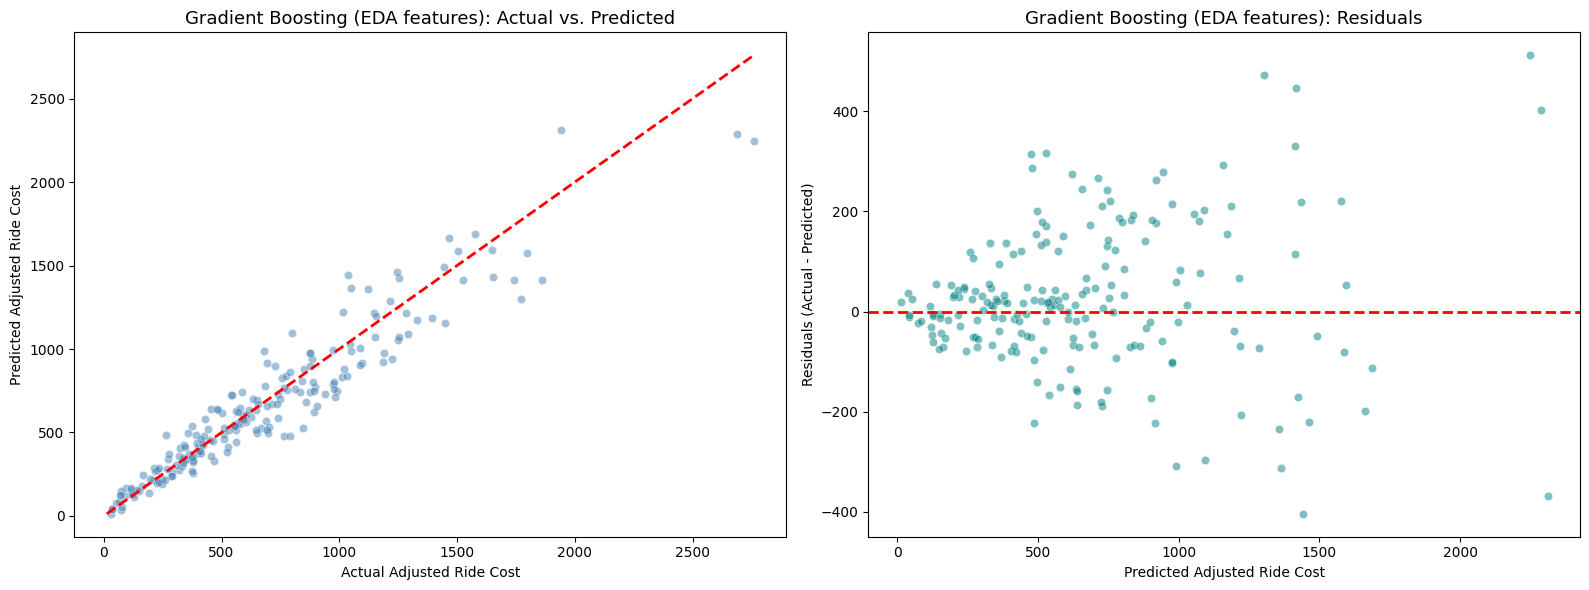

In [105]:
y_pred_e1 = best_model_e1.predict(X_test_e1)
plot_predictions(y_test_e1, y_pred_e1, best_name_e1, label='EDA features')


# 8. Experiment 2 — All Features (No Outlier Removal)

**Features:** All numerical + ordinal + nominal columns.

In [106]:
print('=' * 60)
print('EXPERIMENT 2: All Features — No Outlier Removal')
print('=' * 60)

X_e2 = df[ordinal_features + nominal_features + numerical_features]
y_e2 = df['adjusted_ride_cost']
X_train_e2, X_test_e2, y_train_e2, y_test_e2 = train_test_split(X_e2, y_e2, test_size=0.2, random_state=0)

preprocessor_e2  = build_preprocessor(numerical_features, ordinal_features, nominal_features)
models_config_e2 = build_models_config(include_catboost=False)

results_e2, best_name_e2, best_model_e2 = run_experiment(
    X_train_e2, X_test_e2, y_train_e2, y_test_e2, preprocessor_e2, models_config_e2
)


EXPERIMENT 2: All Features — No Outlier Removal
  Linear Regression: Train $328.42 / R2=0.5447  |  Test $313.41 / R2=0.5446
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $332.70 / R2=0.5328  |  Test $313.73 / R2=0.5436
  Tuning Lasso...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.454e+06, tolerance: 1.506e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.556e+06, tolerance: 1.522e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 10.0}
  Lasso: Train $331.17 / R2=0.5371  |  Test $312.47 / R2=0.5473
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+07, tolerance: 1.544e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+07, tolerance: 1.522e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $331.75 / R2=0.5355  |  Test $313.06 / R2=0.5456
  Tuning Decision Tree...
    Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
  Decision Tree: Train $110.31 / R2=0.9486  |  Test $233.84 / R2=0.7465
  Tuning Random Forest...
    Best params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
  Random Forest: Train $88.92 / R2=0.9666  |  Test $163.69 / R2=0.8758
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
  Gradient Boosting: Train $116.05 / R2=0.9432  |  Test $160.06 / R2=0.8812

>>> Best model: Gradient Boosting
    Test RMSE: $160.06  |  R2: 0.8812

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  328.423906  0.544747  313.405765  0.544573
Ridge              332.702570  0.532808  313.730

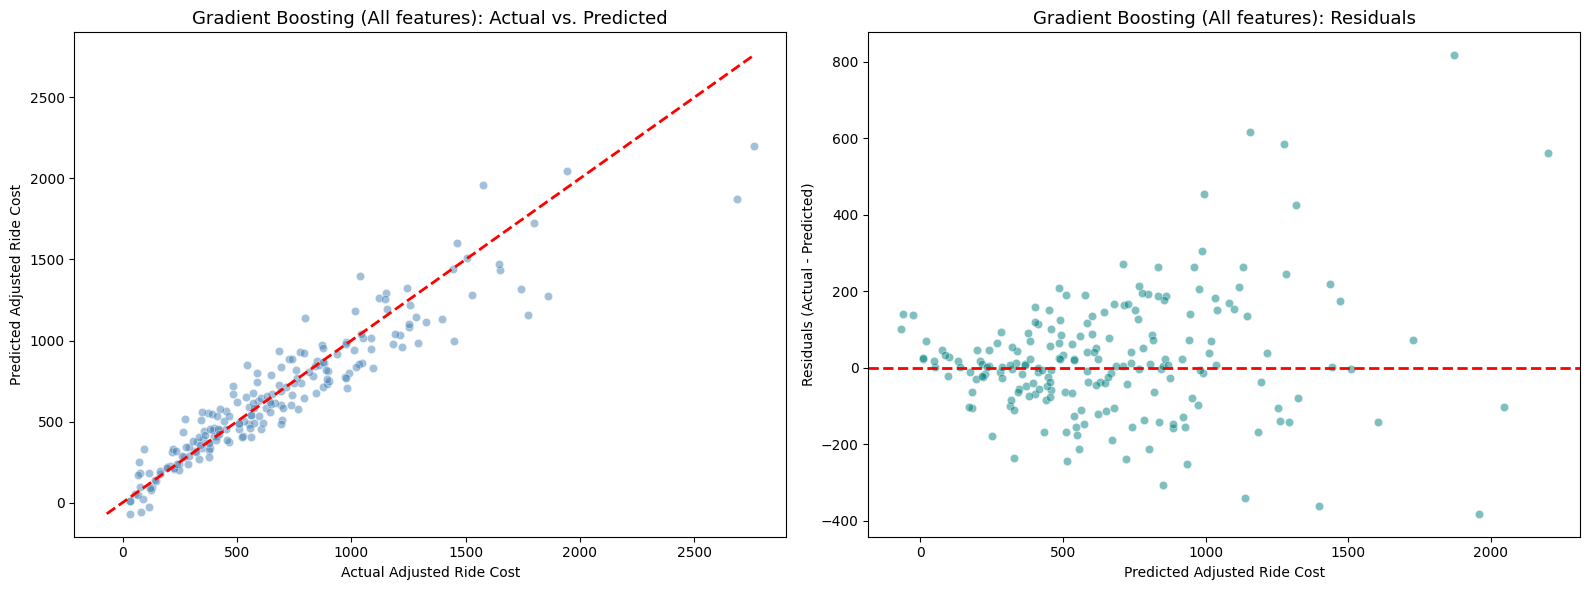

In [107]:
y_pred_e2 = best_model_e2.predict(X_test_e2)
plot_predictions(y_test_e2, y_pred_e2, best_name_e2, label='All features')


# 9. Univariate Outlier Analysis (IQR Method)

Detect outliers in numerical columns before applying removal.

In [108]:
outlier_report = detect_univariate_outliers(df, all_num_cols)
print(outlier_report.to_string(index=False))


               Feature  Lower  Upper  Outliers  Pct (%)
      Number_of_Riders -21.50 142.50         0      0.0
     Number_of_Drivers -29.50  78.50        10      1.0
  Number_of_Past_Rides -50.00 150.00         0      0.0
       Average_Ratings   2.73   5.78         0      0.0
Expected_Ride_Duration -65.12 267.88         0      0.0


## 9a. Experiment 3 — All Features + Univariate Outlier Removal

In [109]:
print('=' * 60)
print('EXPERIMENT 3: All Features — Univariate Outliers Removed')
print('=' * 60)

df_e3 = remove_univariate_outliers(df, all_num_cols)

X_e3 = df_e3[ordinal_features + nominal_features + numerical_features]
y_e3 = df_e3['adjusted_ride_cost']
X_train_e3, X_test_e3, y_train_e3, y_test_e3 = train_test_split(X_e3, y_e3, test_size=0.2, random_state=0)

preprocessor_e3  = build_preprocessor(numerical_features, ordinal_features, nominal_features)
models_config_e3 = build_models_config(include_catboost=False)

results_e3, best_name_e3, best_model_e3 = run_experiment(
    X_train_e3, X_test_e3, y_train_e3, y_test_e3, preprocessor_e3, models_config_e3
)


EXPERIMENT 3: All Features — Univariate Outliers Removed
Original shape: (1000, 10)
  Number_of_Riders: removed 0 rows -> shape (1000, 10)
  Number_of_Drivers: removed 10 rows -> shape (990, 10)
  Number_of_Past_Rides: removed 0 rows -> shape (990, 10)
  Average_Ratings: removed 0 rows -> shape (990, 10)
  Expected_Ride_Duration: removed 0 rows -> shape (990, 10)
  Linear Regression: Train $311.58 / R2=0.5467  |  Test $380.27 / R2=0.5293
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $315.56 / R2=0.5350  |  Test $390.68 / R2=0.5031
  Tuning Lasso...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+06, tolerance: 1.356e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+06, tolerance: 1.432e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 10.0}
  Lasso: Train $314.32 / R2=0.5387  |  Test $385.95 / R2=0.5151
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+07, tolerance: 1.356e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.708e+07, tolerance: 1.432e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $314.64 / R2=0.5377  |  Test $388.89 / R2=0.5077
  Tuning Decision Tree...
    Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
  Decision Tree: Train $126.37 / R2=0.9254  |  Test $287.52 / R2=0.7309
  Tuning Random Forest...
    Best params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train $79.75 / R2=0.9703  |  Test $207.34 / R2=0.8601
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
  Gradient Boosting: Train $116.43 / R2=0.9367  |  Test $203.10 / R2=0.8657

>>> Best model: Gradient Boosting
    Test RMSE: $203.10  |  R2: 0.8657

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  311.579097  0.546703  380.268256  0.529260
Ridge              315.561490  0.535041  390.67

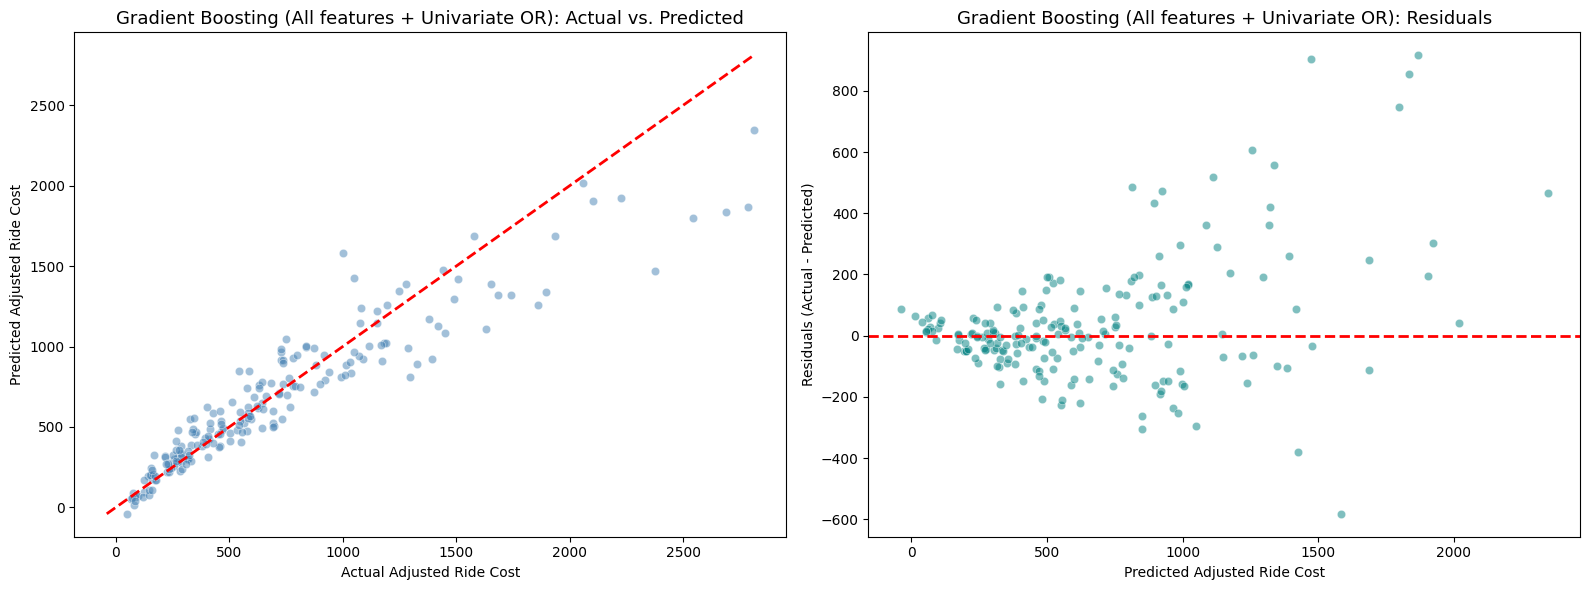

In [110]:
y_pred_e3 = best_model_e3.predict(X_test_e3)
plot_predictions(y_test_e3, y_pred_e3, best_name_e3, label='All features + Univariate OR')


## 9b. Experiment (i) — EDA Features + Univariate Outlier Removal

In [111]:
print('=' * 60)
print('EXPERIMENT (i): EDA Features — Univariate Outliers Removed')
print('=' * 60)

# Use EDA numerical + adjusted_ride_cost for outlier detection scope
eda_num_cols_for_or = eda_numerical_features + ['adjusted_ride_cost']
df_ei = remove_univariate_outliers(df, eda_num_cols_for_or)

X_ei = df_ei[eda_ordinal_features + eda_nominal_features + eda_numerical_features]
y_ei = df_ei['adjusted_ride_cost']
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X_ei, y_ei, test_size=0.2, random_state=0)

preprocessor_ei  = build_preprocessor(eda_numerical_features, eda_ordinal_features, eda_nominal_features)
models_config_ei = build_models_config(include_catboost=False)

results_ei, best_name_ei, best_model_ei = run_experiment(
    X_train_ei, X_test_ei, y_train_ei, y_test_ei, preprocessor_ei, models_config_ei
)


EXPERIMENT (i): EDA Features — Univariate Outliers Removed
Original shape: (1000, 10)
  Number_of_Riders: removed 0 rows -> shape (1000, 10)
  Number_of_Drivers: removed 10 rows -> shape (990, 10)
  Expected_Ride_Duration: removed 0 rows -> shape (990, 10)
  adjusted_ride_cost: removed 39 rows -> shape (951, 10)
  Linear Regression: Train $240.93 / R2=0.5863  |  Test $240.97 / R2=0.5810
  Tuning Ridge...
    Best params: {'model__alpha': 10.0}
  Ridge: Train $240.98 / R2=0.5861  |  Test $241.44 / R2=0.5794
  Tuning Lasso...
    Best params: {'model__alpha': 10.0}
  Lasso: Train $243.23 / R2=0.5784  |  Test $248.23 / R2=0.5554
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+07, tolerance: 8.263e+03
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+07, tolerance: 8.428e+03
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 0.1, 'model__l1_ratio': 0.5}
  Elastic Net: Train $241.58 / R2=0.5840  |  Test $243.01 / R2=0.5739
  Tuning Decision Tree...
    Best params: {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
  Decision Tree: Train $98.10 / R2=0.9314  |  Test $187.71 / R2=0.7457
  Tuning Random Forest...
    Best params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
  Random Forest: Train $54.85 / R2=0.9786  |  Test $154.23 / R2=0.8284
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
  Gradient Boosting: Train $50.82 / R2=0.9816  |  Test $137.72 / R2=0.8631

>>> Best model: Gradient Boosting
    Test RMSE: $137.72  |  R2: 0.8631

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  240.928256  0.586299  240.973274  0.581006
Ridge              240.979188  0.586124  241.4417

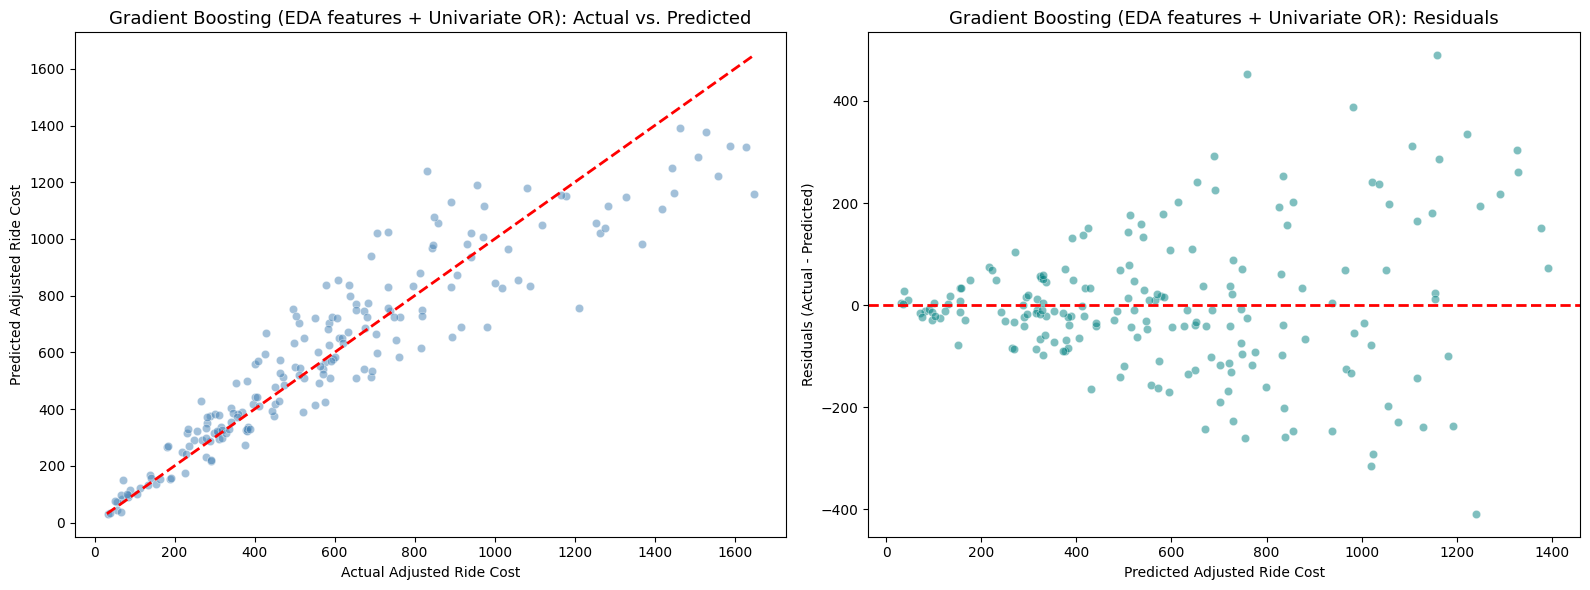

In [112]:
y_pred_ei = best_model_ei.predict(X_test_ei)
plot_predictions(y_test_ei, y_pred_ei, best_name_ei, label='EDA features + Univariate OR')


# 10. Multivariate Outlier Detection — Isolation Forest

## 10a. Experiment 4 — All Features + Multivariate Outlier Removal

> **Note:** Isolation Forest is tree-based; scaling has no effect on results.

In [113]:
print('=' * 60)
print('EXPERIMENT 4: All Features — Multivariate Outliers Removed')
print('=' * 60)

df_e4, outlier_idx_e4 = remove_multivariate_outliers_iso_forest(
    df, numerical_features, ordinal_features, nominal_features
)

X_e4 = df_e4[ordinal_features + nominal_features + numerical_features]
y_e4 = df_e4['adjusted_ride_cost']
X_train_e4, X_test_e4, y_train_e4, y_test_e4 = train_test_split(X_e4, y_e4, test_size=0.2, random_state=0)

preprocessor_e4  = build_preprocessor(numerical_features, ordinal_features, nominal_features)
models_config_e4 = build_models_config(include_catboost=False)

results_e4, best_name_e4, best_model_e4 = run_experiment(
    X_train_e4, X_test_e4, y_train_e4, y_test_e4, preprocessor_e4, models_config_e4
)


EXPERIMENT 4: All Features — Multivariate Outliers Removed
Outliers: 50 (5.0% of data)
Clean data: 950 rows
  Linear Regression: Train $319.37 / R2=0.5519  |  Test $362.38 / R2=0.5139
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $323.63 / R2=0.5398  |  Test $371.44 / R2=0.4893
  Tuning Lasso...
    Best params: {'model__alpha': 10.0}
  Lasso: Train $322.20 / R2=0.5439  |  Test $368.22 / R2=0.4981
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.348e+06, tolerance: 1.424e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.518e+06, tolerance: 1.442e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $322.43 / R2=0.5432  |  Test $369.73 / R2=0.4940
  Tuning Decision Tree...
    Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
  Decision Tree: Train $122.00 / R2=0.9346  |  Test $213.32 / R2=0.8316
  Tuning Random Forest...
    Best params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
  Random Forest: Train $79.87 / R2=0.9720  |  Test $206.65 / R2=0.8419
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
  Gradient Boosting: Train $114.50 / R2=0.9424  |  Test $187.48 / R2=0.8699

>>> Best model: Gradient Boosting
    Test RMSE: $187.48  |  R2: 0.8699

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  319.367024  0.551872  362.384723  0.513919
Ridge              323.632381  0.539822  371.436

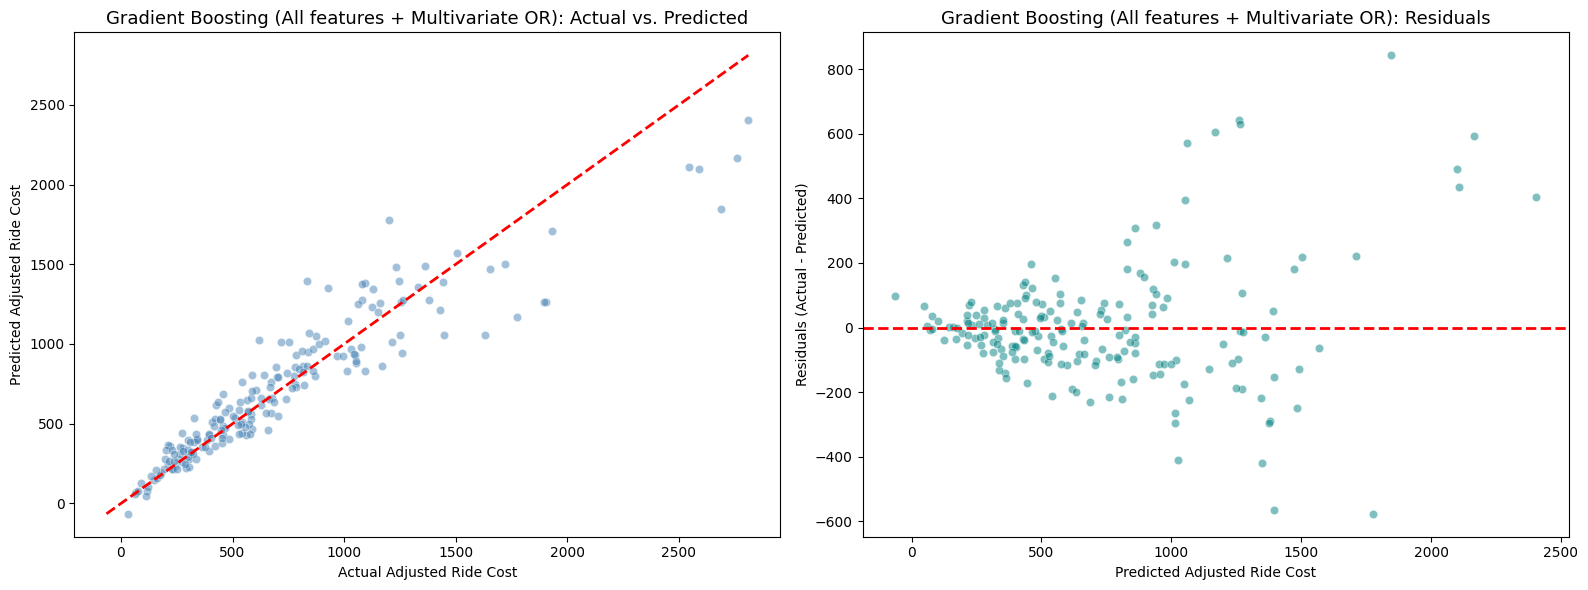

In [114]:
y_pred_e4 = best_model_e4.predict(X_test_e4)
plot_predictions(y_test_e4, y_pred_e4, best_name_e4, label='All features + Multivariate OR')


## 10b. Experiment (ii) — EDA Features + Multivariate Outlier Removal

In [115]:
print('=' * 60)
print('EXPERIMENT (ii): EDA Features — Multivariate Outliers Removed')
print('=' * 60)

df_eii, outlier_idx_eii = remove_multivariate_outliers_iso_forest(
    df, eda_numerical_features, eda_ordinal_features, eda_nominal_features
)

X_eii = df_eii[eda_ordinal_features + eda_nominal_features + eda_numerical_features]
y_eii = df_eii['adjusted_ride_cost']
X_train_eii, X_test_eii, y_train_eii, y_test_eii = train_test_split(X_eii, y_eii, test_size=0.2, random_state=0)

preprocessor_eii  = build_preprocessor(eda_numerical_features, eda_ordinal_features, eda_nominal_features)
models_config_eii = build_models_config(include_catboost=False)

results_eii, best_name_eii, best_model_eii = run_experiment(
    X_train_eii, X_test_eii, y_train_eii, y_test_eii, preprocessor_eii, models_config_eii
)


EXPERIMENT (ii): EDA Features — Multivariate Outliers Removed
Outliers: 50 (5.0% of data)
Clean data: 950 rows
  Linear Regression: Train $328.02 / R2=0.5479  |  Test $337.02 / R2=0.4791
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $332.22 / R2=0.5363  |  Test $340.43 / R2=0.4685
  Tuning Lasso...
    Best params: {'model__alpha': 10.0}
  Lasso: Train $329.90 / R2=0.5427  |  Test $340.60 / R2=0.4680
  Tuning Elastic Net...


/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.355e+06, tolerance: 1.398e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+06, tolerance: 1.447e+04
  model = cd_fast.enet_coordinate_descent(
/Users/viduragunawardana/miniforge3/envs/octaveenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $330.97 / R2=0.5398  |  Test $339.59 / R2=0.4711
  Tuning Decision Tree...
    Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
  Decision Tree: Train $114.55 / R2=0.9449  |  Test $231.64 / R2=0.7539
  Tuning Random Forest...
    Best params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
  Random Forest: Train $67.59 / R2=0.9808  |  Test $196.62 / R2=0.8227
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
  Gradient Boosting: Train $94.96 / R2=0.9621  |  Test $174.97 / R2=0.8596

>>> Best model: Gradient Boosting
    Test RMSE: $174.97  |  R2: 0.8596

Model Comparison:
                   Train_RMSE  Train_R2   Test_RMSE   Test_R2
Linear Regression  328.015462  0.547949  337.015483  0.479113
Ridge              332.222158  0.536280  340.4

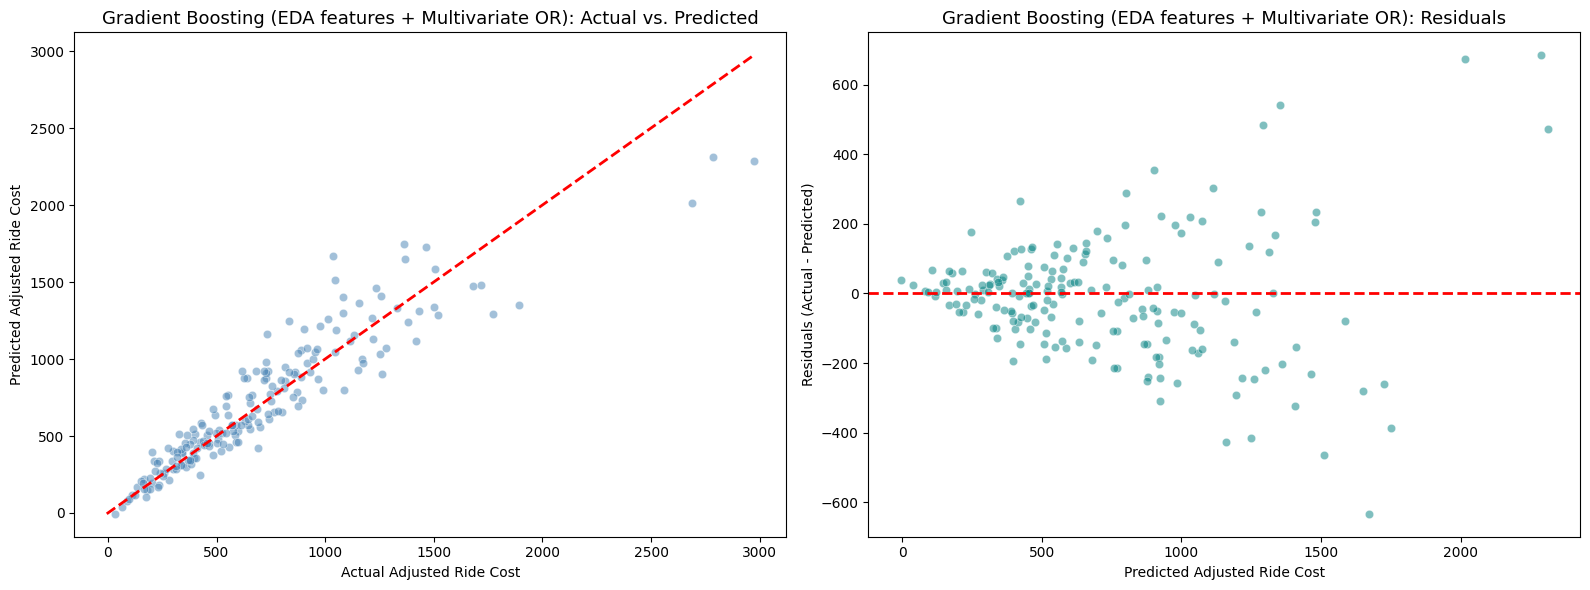

In [116]:
y_pred_eii = best_model_eii.predict(X_test_eii)
plot_predictions(y_test_eii, y_pred_eii, best_name_eii, label='EDA features + Multivariate OR')


# 11. SHAP Feature Importance Analysis

Using the best model from **Experiment 2** (All Features, No Outlier Removal) for SHAP analysis.

In [117]:
# Extract components from Experiment 2's best model
preprocessor_shap  = best_model_e2.named_steps['preprocessor']
model_shap         = best_model_e2.named_steps['model']
feature_names_shap = preprocessor_shap.get_feature_names_out()

print(f'Best model for SHAP: {best_name_e2}')
print(f'Features after preprocessing: {len(feature_names_shap)}')


Best model for SHAP: Gradient Boosting
Features after preprocessing: 14


In [118]:
# Sklearn feature importances (if available)
if hasattr(model_shap, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': feature_names_shap,
        'Importance': model_shap.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f'Top 15 Feature Importances ({best_name_e2}):')
    print(importance_df.head(15).to_string(index=False))
else:
    print('Model does not expose feature_importances_.')


Top 15 Feature Importances (Gradient Boosting):
                         Feature  Importance
     num__Expected_Ride_Duration    0.473262
          num__Number_of_Drivers    0.345583
           num__Number_of_Riders    0.165503
            num__Average_Ratings    0.006041
              vehi__Vehicle_Type    0.004386
       num__Number_of_Past_Rides    0.003094
     nomi__Time_of_Booking_Night    0.000634
nomi__Location_Category_Suburban    0.000540
 nomi__Time_of_Booking_Afternoon    0.000370
   nomi__Location_Category_Rural    0.000248
   loyl__Customer_Loyalty_Status    0.000161
   nomi__Time_of_Booking_Evening    0.000116
   nomi__Location_Category_Urban    0.000050
   nomi__Time_of_Booking_Morning    0.000011


In [119]:
# Preprocess training data for SHAP
X_train_prep = preprocessor_shap.transform(X_train_e2)
if hasattr(X_train_prep, 'toarray'):
    X_train_prep = X_train_prep.toarray()
X_train_prep_df = pd.DataFrame(X_train_prep, columns=feature_names_shap)

explainer   = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_train_prep_df)

print('SHAP values computed.')


SHAP values computed.


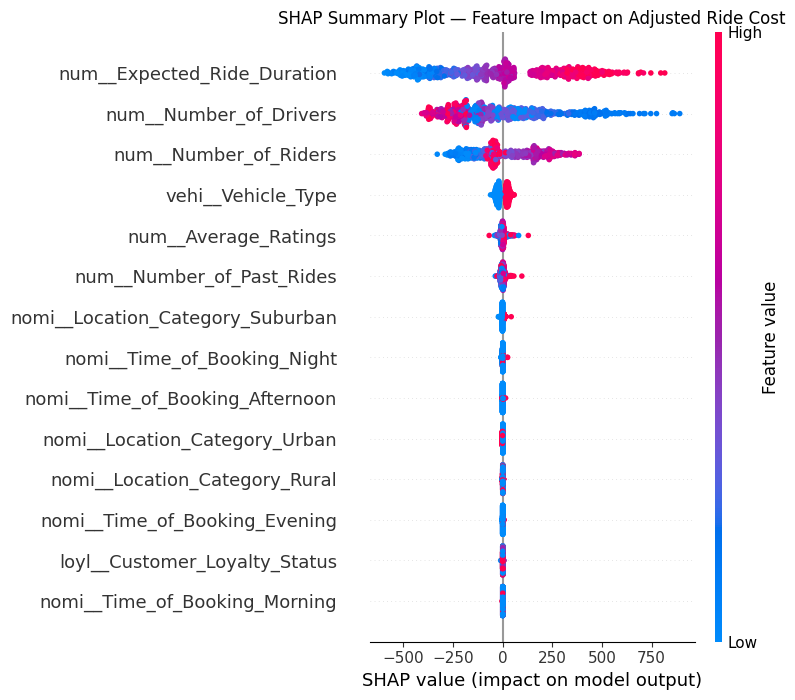

In [120]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_prep_df, plot_type='dot',
                  feature_names=feature_names_shap, show=False)
plt.title('SHAP Summary Plot — Feature Impact on Adjusted Ride Cost')
plt.tight_layout()
plt.show()


Most important feature: num__Expected_Ride_Duration


<Figure size 1000x600 with 0 Axes>

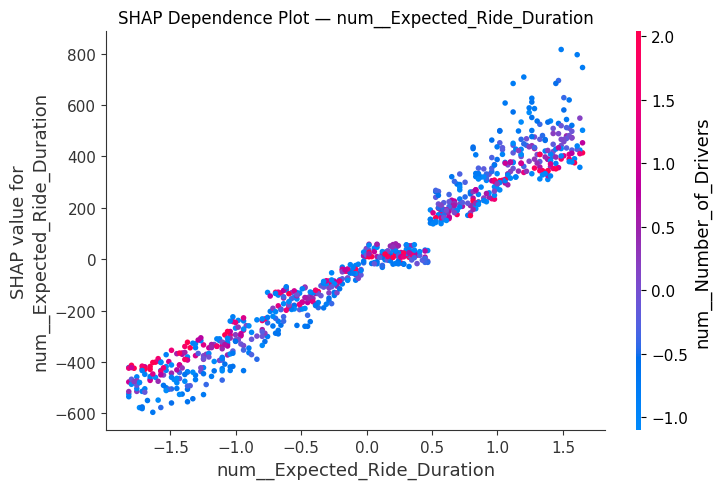

In [121]:
# SHAP Dependence Plot for the top feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_feat_idx  = np.argmax(mean_abs_shap)
top_feat_name = feature_names_shap[top_feat_idx]
print(f'Most important feature: {top_feat_name}')

plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feat_name, shap_values, X_train_prep_df,
                     interaction_index='auto', show=False)
plt.title(f'SHAP Dependence Plot — {top_feat_name}')
plt.tight_layout()
plt.show()


In [122]:
# Aggregate SHAP importance at variable level (handles one-hot expansion)
shap_df_all = pd.DataFrame(shap_values, columns=feature_names_shap, index=X_train_e2.index)

shap_var_importance = {}

for var in nominal_features:
    cols = [c for c in feature_names_shap if c.startswith(f'nomi__{var}')]
    if cols:
        shap_var_importance[var] = np.abs(shap_df_all[cols]).mean().sum()

for var in ordinal_features:
    cols = [c for c in feature_names_shap if var in c]
    if cols:
        shap_var_importance[var] = np.abs(shap_df_all[cols]).mean().sum()

for var in numerical_features:
    cols = [c for c in feature_names_shap if f'num__{var}' in c or c == var]
    if cols:
        shap_var_importance[var] = np.abs(shap_df_all[cols]).mean().sum()

shap_var_df = pd.DataFrame({
    'Variable': list(shap_var_importance.keys()),
    'Mean_Absolute_SHAP': list(shap_var_importance.values())
}).sort_values(by='Mean_Absolute_SHAP', ascending=False).reset_index(drop=True)

print(shap_var_df.to_string(index=False))


               Variable  Mean_Absolute_SHAP
 Expected_Ride_Duration          267.792476
      Number_of_Drivers          205.106819
       Number_of_Riders          135.051176
           Vehicle_Type           25.646696
        Average_Ratings            7.992975
   Number_of_Past_Rides            6.868662
      Location_Category            4.619299
        Time_of_Booking            2.310896
Customer_Loyalty_Status            0.216354


/var/folders/5t/x7zxzmqn0j161t9rg7h4fgj40000gn/T/ipykernel_71112/1426035816.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shap_var_df, x='Mean_Absolute_SHAP', y='Variable', palette='viridis')


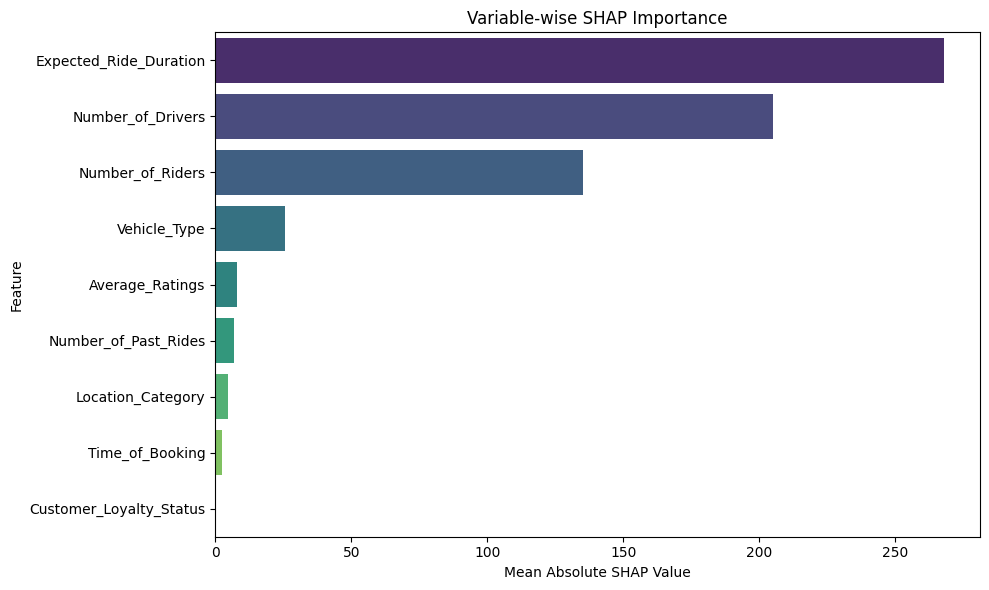

In [123]:
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_var_df, x='Mean_Absolute_SHAP', y='Variable', palette='viridis')
plt.title('Variable-wise SHAP Importance')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# 12. Experiment 6 — Modeling with SHAP-Selected Features

SHAP identified the top 3 numeric drivers: `Number_of_Riders`, `Number_of_Drivers`, `Expected_Ride_Duration`.

This experiment tests whether a simpler model with only these features is competitive.
CatBoost is included here as in the original notebook.

In [124]:
print('=' * 60)
print('EXPERIMENT 6: SHAP-Selected Features')
print('=' * 60)

X_e6 = df[shap_selected_numerical]
y_e6 = df['adjusted_ride_cost']
X_train_e6, X_test_e6, y_train_e6, y_test_e6 = train_test_split(X_e6, y_e6, test_size=0.2, random_state=0)

# Numerical-only preprocessor (no ordinal/nominal needed)
preprocessor_e6 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), shap_selected_numerical)
])
models_config_e6 = build_models_config(include_catboost=True)

results_e6, best_name_e6, best_model_e6 = run_experiment(
    X_train_e6, X_test_e6, y_train_e6, y_test_e6, preprocessor_e6, models_config_e6
)


EXPERIMENT 6: SHAP-Selected Features
  Linear Regression: Train $332.09 / R2=0.5345  |  Test $313.19 / R2=0.5452
  Tuning Ridge...
    Best params: {'model__alpha': 100.0}
  Ridge: Train $335.94 / R2=0.5237  |  Test $313.97 / R2=0.5429
  Tuning Lasso...
    Best params: {'model__alpha': 10.0}
  Lasso: Train $333.02 / R2=0.5319  |  Test $312.10 / R2=0.5484
  Tuning Elastic Net...
    Best params: {'model__alpha': 1.0, 'model__l1_ratio': 0.9}
  Elastic Net: Train $334.98 / R2=0.5264  |  Test $313.32 / R2=0.5448
  Tuning Decision Tree...
    Best params: {'model__max_depth': 15, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
  Decision Tree: Train $134.04 / R2=0.9242  |  Test $187.30 / R2=0.8373
  Tuning Random Forest...
    Best params: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}
  Random Forest: Train $90.71 / R2=0.9653  |  Test $153.88 / R2=0.8902
  Tuning Gradient Boosting...
    Best params: {'model__learning_rate': 0.1, 'model__

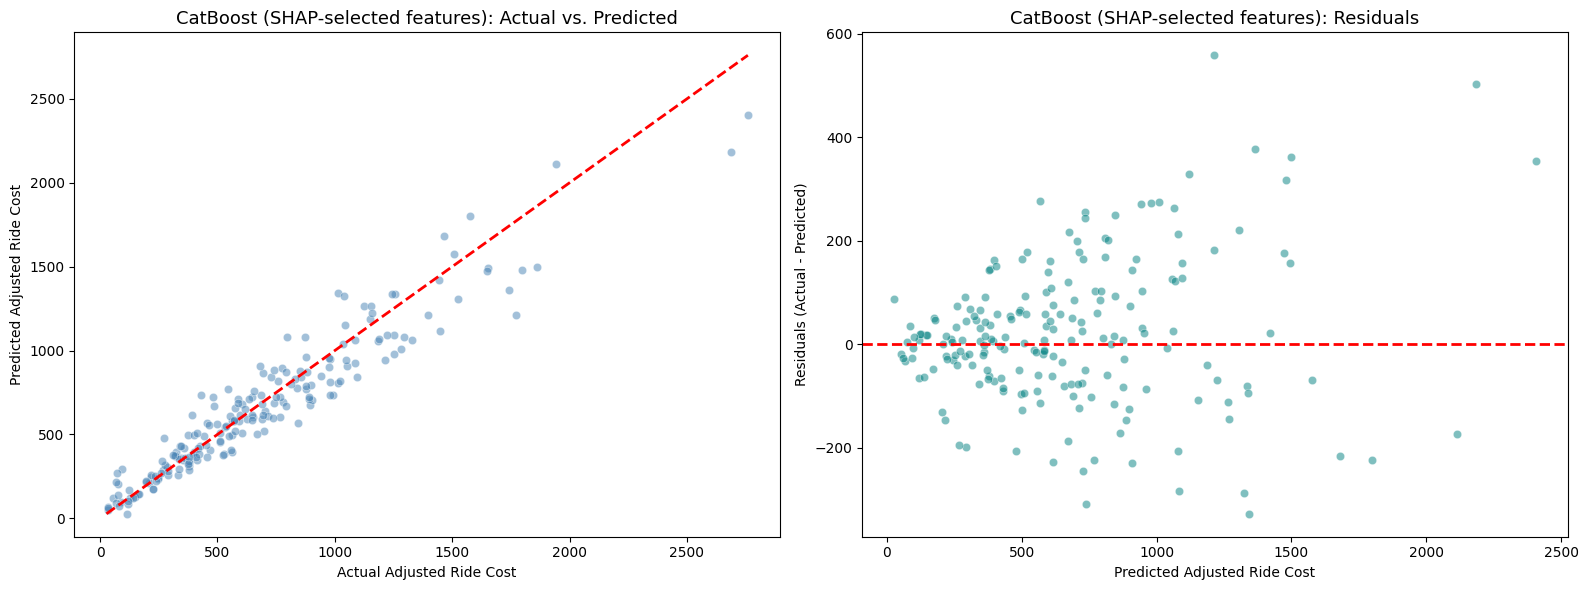

In [125]:
y_pred_e6 = best_model_e6.predict(X_test_e6)
plot_predictions(y_test_e6, y_pred_e6, best_name_e6, label='SHAP-selected features')


# 13. Export Best Models

Each experiment's best pipeline (preprocessor + model) is saved to `exported_models/` as a pickle file so it can be loaded and used in production without re-training.

In [ ]:
models_to_export = {
    # 'exp1_eda_features':          best_model_e1,
    # 'exp2_all_features':          best_model_e2,
    # 'exp3_all_univariate_or':     best_model_e3,
    # 'exp4_all_multivariate_or':   best_model_e4,
    'exp6_shap_features':         best_model_e6,
    # 'expi_eda_univariate_or':     best_model_ei,
    # 'expii_eda_multivariate_or':  best_model_eii,
}

for model_key, pipeline in models_to_export.items():
    out_path = f'./{model_key}.pkl'
    with open(out_path, 'wb') as f:
        pickle.dump(pipeline, f)
    print(f'Saved: {out_path}')

print(f'\n{len(models_to_export)} models exported to {EXPORT_DIR.resolve()}')


Saved: exported_models/exp1_eda_features.pkl
Saved: exported_models/exp2_all_features.pkl
Saved: exported_models/exp3_all_univariate_or.pkl
Saved: exported_models/exp4_all_multivariate_or.pkl
Saved: exported_models/exp6_shap_features.pkl
Saved: exported_models/expi_eda_univariate_or.pkl
Saved: exported_models/expii_eda_multivariate_or.pkl

7 models exported to /Users/viduragunawardana/Code/DataScience/Python/SurgePricing/exported_models


In [127]:
# Quick verification — reload one model and confirm predictions match
with open(EXPORT_DIR / 'exp2_all_features.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

reloaded_preds = loaded_model.predict(X_test_e2)
original_preds = best_model_e2.predict(X_test_e2)
assert np.allclose(reloaded_preds, original_preds), 'Mismatch after reload!'
print('Model reload verification PASSED — predictions match.')


Model reload verification PASSED — predictions match.
